# Explore Model Embeddings

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

ModuleNotFoundError: No module named 'shap'

In [ ]:
# EXPERIMENT =      'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
EXPERIMENT =      'one_month_forecast'
# TRUE_EXPERIMENT = 'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
TRUE_EXPERIMENT = 'one_month_forecast'
TARGET_VAR =      'boku_VCI'

assert (data_dir / f'models/{EXPERIMENT}').exists()
assert (data_dir / f'models/{TRUE_EXPERIMENT}').exists()

print((data_dir / f'models/{EXPERIMENT}').as_posix())

# Read in the data

In [ ]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [ ]:
print("TRAINING DATA")
display(ds)
print('\n\n')
print("TARGET DATA")
display(y_test)

In [ ]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

# bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
# lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)

In [ ]:
fig, ax = plt.subplots()
time_ix = 0
time = ealstm_pred.isel(time=time_ix).time.values
ealstm_pred.isel(time=time_ix).plot(ax=ax)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0]}**", size=16);

# Read in the models
Input data:
* boku_VCI    
* pev         
* t2m         
* precip      
* E           
* SMroot      
* SMsurf


\+ each variables SPATIAL MEAN (therefore 14 input variables)

In [ ]:
from src.models import load_model

In [ ]:
ealstm = load_model(data_dir / 'models' / EXPERIMENT / 'ealstm' / 'model.pt')
# lstm = load_model(data_dir / 'models' / EXPERIMENT / 'rnn' / 'model.pt')

In [ ]:
ealstm.models_dir = data_dir / 'models' / EXPERIMENT
# lstm.models_dir = data_dir / 'models' / EXPERIMENT

ealstm.experiment = TRUE_EXPERIMENT
ealstm.features_per_month  # x.shape[-1] = the number of features in dynamic data 

In [ ]:
ealstm.ignore_vars

# checks of the static data

In [ ]:
dl = ealstm.get_dataloader('train', batch_file_size=1, shuffle_data=False)
train_iter = iter(dl)
static_data = train_iter.static
static_data

In [ ]:
global_vars = [v for v in static_data if 'global' in v]
pixel_vars = [v for v in static_data if 'pixel' in v]

fig, ax = plt.subplots()
static_data[global_vars[0]].plot(ax=ax)
fig, ax = plt.subplots()
static_data[pixel_vars[0]].plot(ax=ax)

# Interpret Model Static layer

In [ ]:
dir(ealstm)

In [ ]:
# ealstm.yearly_agg_size
ealstm.model.static_embedding

In [ ]:
from typing import Tuple


def sigmoid(x):
    return 1/(1 + np.exp(-x))


def build_static_x(x: Tuple[np.array], ) -> Tuple[List[np.array], List[np.array], List[np.array]]:
    all_static_x = []
    all_latlons = []
    all_pred_months = []

    for i in range(len(x)):  # EACH BATCH (of X,y pairs)
        pred_month_data = x[i][1]
        latlons_data = x[i][2]
        yearly_aggs_data = x[i][4]
        static_data = x[i][5]
        assert static_data.shape[-1] == 29, f"{static_data.shape}"
        # print()
        # print("pred_month_data.shape", (pred_month_data.shape[0], 12) if pred_month_data is not None else "None")
        # print("latlons_data.shape", latlons_data.shape if latlons_data is not None else "None")
        # print("yearly_aggs_data.shape", yearly_aggs_data.shape if yearly_aggs_data is not None else "None")
        # print("static_data.shape", static_data.shape if static_data is not None else "None")
        # break
        
        # append the static_arrays
        static_x = []
        # normalise latlon
        static_x.append((latlons_data - latlons_data.mean(axis=0)) / latlons_data.std(axis=0))  # 0, 1
        static_x.append(yearly_aggs_data)  # 2: 9
        static_x.append(static_data)
        # one_hot_encode the pred_month_data
        try:
            static_x.append(ealstm._one_hot(torch.from_numpy(pred_month_data), 12).numpy())
        except TypeError:
            static_x.append(ealstm._one_hot(torch.from_numpy(pred_month_data), 12).cpu().numpy())
        
        # exclude Nones
        static_x = np.concatenate([x for x in static_x if x is not None], axis=-1)
        # print("Static X Data Shape: ", static_x.shape)
        
        # all data
        all_static_x.append(static_x)

        # metadata (latlons and pred_months)
        all_latlons.append(latlons_data)
        all_pred_months.append(pred_month_data)
        
    return all_static_x, all_latlons, all_pred_months


def calculate_embeddings(static_x: np.ndarray, W: np.ndarray, b: np.array) -> np.array:
    assert W.T.shape[0] == static_x.shape[-1], f"Matrix operations must be valid {static_x.shape} * {W.T.shape}"
    
    embedding = []
    for pixel_ix in range(static_x.shape[0]):
        embedding.append(sigmoid(np.dot(W, static_x[pixel_ix]) + b))
    return np.array(embedding)


def get_train_mask(ealstm):
    val_split = 0.1
    len_mask = len(
        DataLoader._load_datasets(
            ealstm.data_path,
            mode="train",
            experiment=EXPERIMENT,
            shuffle_data=False,
            pred_months=None,
        )
    )
    train_mask, val_mask = train_val_mask(len_mask, val_split)
    return train_mask


def get_static_embedding(ealstm) -> Tuple[List[np.array], Tuple[List[np.array], np.array, List[np.array]]]:
    # get W, b from state_dict
    od = ealstm.model.static_embedding.state_dict()
    try:
        W = od['weight'].numpy()
        b = od['bias'].numpy()
    except TypeError:
        W = od['weight'].cpu().numpy()
        b = od['bias'].cpu().numpy()
        
    # get X_static data from dataloader
    print("Calling Training DataLoader")
    dl = ealstm.get_dataloader('train', batch_file_size=1, shuffle_data=False)
    x = [x for (x, y) in dl]
        
    # build static_x matrix
    all_static_x, all_latlons, all_pred_months = build_static_x(x)
    # check w^Tx + b is a valid matrix operation
    assert W.T.shape[0] == all_static_x[0].shape[-1], f"W.T shape: {W.T.shape} static_x shape: {all_static_x[0].shape}"
    
    # calculate the embeddings
    all_embeddings = []
    for static_x in all_static_x:
        embedding = calculate_embeddings(static_x, W=W, b=b)
        all_embeddings.append(embedding)
        
    return all_embeddings, (all_static_x, np.array(all_latlons), np.array(all_pred_months))

all_e, (all_static_x, all_latlons, all_pred_months) = get_static_embedding(ealstm=ealstm)

#### TODO: why do these exist?
- Remove the static months where there are more than one pred_months
- there should only be one pred_month per static embedding

In [ ]:
pred_months_err_mask = [len(np.unique(pm)) == 1 for pm in all_pred_months]
all_e = np.array(all_e)[pred_months_err_mask]
all_static_x = np.array(all_static_x)[pred_months_err_mask]
all_pred_months = np.array(all_pred_months)[pred_months_err_mask]
all_latlons = np.array(all_latlons)[pred_months_err_mask]

assert all_latlons.shape == all_static_x.shape
assert all_pred_months.shape == all_e.shape

# assert all timsteps have only 1 pred month
assert all([i == 1 for i in [len(np.unique(pm)) for pm in all_pred_months]])

### Sort by the pred month

In [ ]:
def sort_by_another_list(list_to_sort, list_to_sort_on):
    assert len(list_to_sort) == len(list_to_sort_on)
    sort_ixs = np.argsort(list_to_sort_on)
    return list_to_sort[sort_ixs]


# SORTBY month
pred_months = [int(np.unique(pm)) for pm in all_pred_months]

all_e = sort_by_another_list(all_e, pred_months)
all_static_x = sort_by_another_list(all_static_x, pred_months)
all_latlons = sort_by_another_list(all_latlons, pred_months)
all_pred_months = sort_by_another_list(all_pred_months, pred_months)

In [ ]:
print(len(all_e))
[emb.shape for emb in all_e]
print(len(all_latlons))

# Are they actually Static?

In [ ]:
pred_months = [int(np.unique(pm)) for pm in all_pred_months]
pred_months

In [ ]:
import calendar
# get the unique indexes of the months (from pred_months)
unique_ids = [pred_months.index(x) for x in set(pred_months)]

# check the first for that month against the others for that month
for id_1, id_2, month in zip(unique_ids, [id_ + 1 for id_ in unique_ids], set(pred_months)):
    mth = calendar.month_abbr[month]
    if all_e[id_1].shape == all_e[id_2].shape:
        print(f"1 {mth}: ", np.all(all_e[id_1] == all_e[id_2]))
    elif all_e[id_1 + 1].shape == all_e[id_2 + 1].shape:
        print(f"2 {mth}: ", np.all(all_e[id_1 + 1] == all_e[id_2 + 1]))
    elif all_e[id_1 + 1].shape == all_e[id_2 + 2].shape:
        print(f"3 {mth}: ", np.all(all_e[id_1 + 1] == all_e[id_2 + 2]))
    elif all_e[id_1 + 1].shape == all_e[id_2 + 3].shape:
        print(f"4 {mth}: ", np.all(all_e[id_1 + 1] == all_e[id_2 + 3]))
    elif all_e[id_1 + 1].shape == all_e[id_2 + 4].shape:
        print(f"5 {mth}: ", np.all(all_e[id_1 + 1] == all_e[id_2 + 4]))
    else:
        print(f"# {mth}: UNABLE TO FIND matching shape")

In [ ]:
unique_ids = [pred_months.index(x) for x in set(pred_months)]

month_embeddings = all_e[unique_ids]
month_static_x = all_static_x[unique_ids]
month_latlons = all_latlons[unique_ids]
month_pred_months = all_pred_months[unique_ids]
month_pred_months = [np.unique(m)[0] for m in month_pred_months]

In [ ]:
len(month_embeddings)

# Visualise the Static Embedding

In [ ]:
import calendar

for embedding, pred_month in zip(month_embeddings, month_pred_months):
    # embedding = all_embeddings[0]
    fig, ax = plt.subplots(figsize=(12,5))
    img = ax.pcolor(embedding.T, cmap='plasma')
    ax.set_xlabel("Pixels")
    ax.set_ylabel("Input gate neuron")
    month = [m for m in calendar.month_abbr][pred_month]
    ax.set_title(f"Input gate activations {month}")
    cbar = plt.colorbar(img, ax=ax)
    cbar.ax.set_ylabel("Activation")

In [ ]:
# create embedding dataset
def build_xarray_object(embedding_matrix: np.array, ix):
    return (
        pd.DataFrame(embedding_matrix)
        .reset_index()
        .rename(columns={'index': 'pixel'})
        .melt(id_vars='pixel')
        .rename(columns={'variable': 'neuron', 'value': f'activation_{ix:03d}'})
        .set_index(['pixel', 'neuron'])
        .to_xarray()
    )

all_ds = []
for ix, embedding_matrix in enumerate(all_e):
    all_ds.append(build_xarray_object(embedding_matrix, ix))
    break
    
ds = xr.auto_combine(all_ds)
ds

# How does this vary over each MONTH ?

In [ ]:
# Taken directly from Kratzert et al (2019) 
# https://github.com/kratzert/ealstm_regional_modeling/blob/master/papercode/clusterutils.py
from collections import defaultdict
from typing import List, Dict, Union
from sklearn.cluster import KMeans


def fit_kmeans(array: np.array, ks: List[int] = [4]) -> Dict[int, Dict[int, int]]:
    clusters = {k: {} for k in ks}
    for k in ks:
        clusterer = KMeans(n_clusters=k, random_state=0, init='k-means++',
                           n_init=200).fit(array)

        for pixel in range(array.shape[0]):
            arr = array[pixel, :]
            clusters[k][pixel] = clusterer.predict(arr.reshape(1, -1))[0]
    return clusters


def convert_clusters_to_ds(ks: List[int], static_clusters: Dict[int, np.array], pixels: np.ndarray, latitudes: np.ndarray, longitudes: np.ndarray, time: Union[pd.Timestamp, int] = 1) -> xr.Dataset:
    out = []
    for k in ks:
        cluster = np.array([v for v in static_clusters[k].values()])
        coords = {'pixel': pixels}
        dims = ['pixel']
        cluster_ds = xr.Dataset({f'cluster_{k}': (dims, cluster), 'lat': (dims, latitudes), 'lon': (dims, longitudes), 'time': (dims, [time for _ in range(len(latitudes))])})
        out.append(cluster_ds)
    
    static_cluster_ds = xr.auto_combine(out)
    static_cluster_ds = static_cluster_ds.to_dataframe().set_index(['time', 'lat','lon']).to_xarray()
    
    return static_cluster_ds


def plot_cluster_ds(ks: List[int], static_cluster_ds: xr.Dataset, month_abbr: str = ''):
    for k in ks:
        fig, ax = plt.subplots(figsize=(12,8))
        static_cluster_ds[f'cluster_{k}'].plot(ax=ax)
        ax.set_title(f'Output of Static Embedding Clustering [k={k}]\n{month_abbr}');

        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]): # + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(20)
            



In [ ]:
# len(all_e)
# embedding.shape
# latlons.shape

print(len(month_embeddings))
print(len(month_pred_months))
print(len(month_latlons))

In [ ]:
# n clusters 

# calculate clusters for ALL x.nc inputs
all_cluster_ds = []

for ix, (embedding, pred_month, latlons) in enumerate(zip(
    month_embeddings, 
    month_pred_months, 
    month_latlons
)):
    ks = [5]
    
    # fit the clusters
    static_clusters = fit_kmeans(embedding, ks)
    print(f"Fitted KMeans {ix}") if ix % 10 == 0 else None
    
    # convert to dataset
    pixels = latlons
    lons = latlons[:, 1] 
    lats = latlons[:, 0] 
    static_cluster_ds = convert_clusters_to_ds(ks, static_clusters, pixels, lats, lons, time=ix)
    print(f"Convert to ds {ix}") if ix % 10 == 0 else None
    
    # append to final list
    all_cluster_ds.append(static_cluster_ds)

# combine into one xr.Dataset
cluster_ds = xr.auto_combine(all_cluster_ds)

In [ ]:
cluster_ds

In [ ]:
if not (data_dir / f"tommy/static_embeddings.nc").exists():
    cluster_ds.to_netcdf(data_dir / f"tommy/static_embeddings.nc")
else:
    print(f"Already saved to: {(data_dir / 'tommy/static_embeddings.nc').as_posix()}")

# Plot KMeans for each of the embeddings
TODO: Get the colors the same like the Kratzert code!

In [ ]:
# m_abbrs = [m for m in calendar.month_abbr]

# for embedding, pred_month, latlons in zip(
#     month_embeddings, 
#     month_pred_months, 
#     month_latlons
# ):
#     ks = [5]
#     static_clusters = fit_kmeans(embedding, ks)
    
#     # create ds
#     pixels = latlons
#     lons = latlons[:, 1] 
#     lats = latlons[:, 0] 
#     static_cluster_ds = convert_clusters_to_ds(ks, static_clusters, pixels, lats, lons)
    
#     # plot ds
#     month_abbr = m_abbrs[pred_month]
#     plot_cluster_ds(ks, static_cluster_ds, month_abbr=month_abbr)

In [ ]:
# ?ax.imshow
# https://stackoverflow.com/a/52323085/9940782
# https://stackoverflow.com/a/9708079/9940782
from matplotlib.colors import ListedColormap

# colors = sns.color_palette('viridis', 6)
#          yellow,    green,    turqoise,   blue,      purple
colors = np.array(['#fde832', '#67c962', '#43928d', '#3b528b', '#461954'])
cmap = ListedColormap(colors)

## get the matching/closest embeddings
## assign a color to the values
fig, ax = plt.subplots()

k_matrix = cluster_ds.isel(time=-1).cluster_5.values[::-1, :]
ax.imshow(k_matrix, cmap=cmap)

In [ ]:
sns.palplot(colors)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cluster_ds.isel(time=0).cluster_5.values[::-1, :], cmap=cmap)
axs[1].imshow(cluster_ds.isel(time=1).cluster_5.values[::-1, :], cmap=cmap)

In [ ]:
colors[[4, 2, 1, 3, 0]]

In [ ]:
sns.palplot(colors)
sns.palplot(colors[[4, 2, 1, 3, 0]])

# 0->4, 1->2, 2->1, 3=3, 4->0
new_cmap = ListedColormap(colors[np.array([4, 2, 1, 3, 0])])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cluster_ds.isel(time=0).cluster_5.values[::-1, :], cmap=cmap)
axs[1].imshow(cluster_ds.isel(time=1).cluster_5.values[::-1, :], cmap=new_cmap)

In [ ]:
jan = cluster_ds.isel(time=0).cluster_5
feb = cluster_ds.isel(time=1).cluster_5

# jan = cluster_ds.isel(time=0).cluster_5.values[::-1, :]
# feb = cluster_ds.isel(time=1).cluster_5.values[::-1, :]

comparison_ds = feb
reference_ds = jan

In [ ]:
def get_matching_groups(
    reference_ds: xr.DataArray, comparison_ds: xr.DataArray
) -> Tuple[Dict[float, float], pd.DataFrame]:
    # get the unique values from the reference_ds
    group_vals = np.unique(reference_ds.values[~np.isnan(reference_ds.values)])

    # calculate the number of matching pixels
    df = convert_counts_dict_to_dataframe(
        count_matching_pixels(reference_ds, comparison_ds)
    )

    # check that the groups are matching / all groups are included
    assert all(np.isin(np.unique(df.group_0.values), group_vals))
    assert all(np.isin(np.unique(df.group_1.values), group_vals))

    # calculate_the remap_dict
    remap_dict = most_overlapping_pixels_algorithm(df)

    # check all values in group_vals are in the dict keys
    assert all(np.isin([k for k in remap_dict.keys()], group_vals))

    return remap_dict, df


def count_matching_pixels(reference_ds: xr.Dataset, comparison_ds: xr.Dataset) -> Dict[float, Dict[float, float]]:
    """Count the number of pixels for each value
        in comparison_ds for each reference value
        in reference_ds

    Returns:
    -------
     Dict[float, Dict[float, float]]
        keys = reference_ds values
        values = {comparison_ds values: count of matches}
    """
    unique_counts = dict()

    # for each reference value in reference_ds
    # excluding np.nan
    for value in np.unique(reference_ds.values[~np.isnan(reference_ds.values)]):
        # get the pixels from Comparison corresponding to `value` in Reference
        np_arr = comparison_ds.where(reference_ds == value).values
        # drop nans from matching values
        np_arr = np_arr[~np.isnan(np_arr)]
        # calculate the number of group_1 pixels
        counts = np.unique(np_arr, return_counts=True)
        unique_counts[value] = dict(zip(counts[0], counts[1]))

    return unique_counts


def convert_counts_dict_to_dataframe(unique_counts: dict) -> pd.DataFrame:
    """create long format dataframe from counts in unique_counts"""
    df = pd.DataFrame(unique_counts)  # rows = group_1_values, cols = group_0_values
    df.columns = df.columns.rename('group_0')
    df.index = df.index.rename('group_1')
    # 2D -> 1D idx, group_0, group_1, count
    df = df.unstack().reset_index().rename(columns={0:'count'})

    counts = df.groupby('group_1')['count'].sum()
    df['pct'] = df.apply(lamba x: x['count'] / counts.iloc[x.group_1], axis=1)
    assert False

    return df


def get_max_count_row(df: pd.DataFrame) -> pd.Series:
    """Get the row with the largest count from df"""
    return df.loc[df['count'].idxmax()]


def drop_already_assigned_values(
    df: pd.DataFrame,
    assigned_group_values: List[float],
) -> pd.DataFrame:
    """drop the values that have been assigned (added to the lists)
    """
    # remove the matches from group_1
    df = df.loc[~np.isin(df.group_1, assigned_group_values)]
    # remove the matches from group_0
#     df = df.loc[~np.isin(df.group_0, assigned_group_values)]
    return df


def calculate_remap_dict(group_0_list: List[float], group_1_list: List[float]) -> Dict[float, float]:
    """create dictionary object containing the mapping from reference_group -> comparison_group"""
    remap_dict = dict()
    # TODO: THis assumption is not true it's not symmetrical
    # remap dict is symmetrical:
    # values in group_0->group_1 are the same mapping as group_1-> group_0
    remap_dict.update(dict(zip(group_0_list, group_1_list)))
    remap_dict.update(dict(zip(remap_dict.values(), remap_dict.keys())))

    # sort the remap_dict
    remap_dict = {k :remap_dict[k]  for k in sorted(remap_dict)}

    return remap_dict


def most_overlapping_pixels_algorithm(df: pd.DataFrame) -> Dict[float, float]:
    """match the 'closest' group from group_0 in group_1"""
    assert all(np.isin(["group_0", "group_1"], [c for c in df.columns])), f"Need columns group_0 group_1. Found: {df.columns}"
    # get the counts of each pixel value/group (excl. nans) and select the most cross-overs
    # order is important so we do the BEST match first
    # get the largest first
    group_0_list = []
    group_1_list = []

    # match each reference_group to closest matching comparison_group
    # track progress by removing the matches that have already been made
    # from the dataframe
    while df.shape[0] > 0:
        # IF only one group-value left, assign it to the final remaining group (itself)
        if len(df.group_1.unique()) == 1:
            # final value is itself
            # remap_dict[df.group_1.unique()[0]] = df.group_1.unique()[0]
            group_0_list.append(df.group_1.unique()[0])
            group_1_list.append(df.group_1.unique()[0])
            df = drop_already_assigned_values(
                df, group_1_list + group_0_list
            )

        else:
            # otherwise match to the closest remaining match (most overlapping pixels)
            max_count_row = get_max_count_row(df)
            group_0_list.append(
                max_count_row.group_0
            )
            group_1_list.append(
                max_count_row.group_1
            )

            # drop_already_assigned_values
            df = drop_already_assigned_values(
                df, group_1_list+group_0_list
            )

    remap_dict = calculate_remap_dict(group_0_list, group_1_list)

    return remap_dict


# Plotting helper functions
def plot_colors_remapping(colors, remap_dict) -> None:
    colors_remapped = [[int(v) for v in remap_dict.values()]]
    sns.palplot(colors)
    sns.palplot(colors_remapped)


def replace_with_dict2(ar: np.array, dic: Dict) -> np.array:
    """Replace the values in an np.ndarray with a dictionary

    https://stackoverflow.com/a/47171600/9940782
    """
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()

    ks = k[sidx]
    vs = v[sidx]
    warnings.warn("We are taking one from the index. need to check this is true!!!")
    return vs[np.searchsorted(ks, ar) - 1]


def remap_xarray_values(
    xr_obj: Union[xr.Dataset, xr.DataArray],
    lookup_dict: Dict,
    new_variable: str,
    overwrite: bool = True,
    variable: Optional[str] = None,
) -> Union[xr.Dataset, xr.DataArray]:
    """ remap values in xr_obj using lookup_dict.
    Arguments:
    ---------
    : xr_obj (xr.Dataset, xr.DataArray)
        the xarray object we want to look values up from
    : variable (str)
        the INPUT variable we are hoping to look the values up from (the dictionary keys)
    : new_variable (str)
        the name of the OUTPUT variable we want to put the dictionary values in
    : lookup_dict (dict)
        the dictionary we want to lookup the values of 'variable' in to return values to 'new_variable'
    : overwrite (bool)
        True = return a new xr_obj with the remapped values
        False = Assign a new Variable to the xr_obj
    """
    # get the values as a numpy array
    if isinstance(xr_obj, xr.Dataset):
        assert variable is not None
        assert variable in list(ds.data_vars), f"variable is not in {list(ds.data_vars)}"
        ar = xr_obj[variable].values
    elif isinstance(xr_obj, xr.DataArray):
        ar = xr_obj.values
    else:
        assert (
            False
        ), "This function only works with xarray objects." \
        f"Currently xr_obj is type: {type(xr_obj)}"

    assert isinstance(ar, np.ndarray), f"ar should be a numpy array!"
    assert isinstance(lookup_dict, dict), f"lookup_dict should be a dictionary object!"

    # replace values in a numpy array with the values from the lookup_dict
    new_ar = replace_with_dict2(ar, lookup_dict)

    # assign the values looked up from the dictionary to a new variable in the xr_obj
    new_da = xr.DataArray(new_ar, coords=[xr_obj.lat, xr_obj.lon], dims=["lat", "lon"])
    if new_variable is not None:
        new_da.name = new_variable
    if not overwrite:
        new_da = xr.merge([xr_obj, new_da])

    return new_da


remap_dict, matches_df = get_matching_groups(reference_ds, comparison_ds)

print(remap_dict)

# remap_xarray_values(
#     comparison_ds, new_variable='cluster_5',
#     lookup_dict=remap_dict,
#     overwrite=True
# )

In [ ]:
assigned_group_values = []
display(matches_df.head(7))
display(matches_df.groupby('group_1')['count'].sum())

# 1.
# get matches
max_row = get_max_count_row(matches_df)
assigned_group_values += [max_row.group_1]
# drop_already_assigned_values
df = matches_df.loc[~np.isin(matches_df.group_1, assigned_group_values)]

# 2.
max_row = get_max_count_row(df)
assigned_group_values += [max_row.group_1]

In [ ]:
colors_remapped

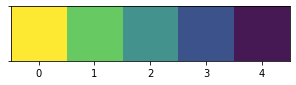

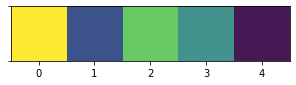

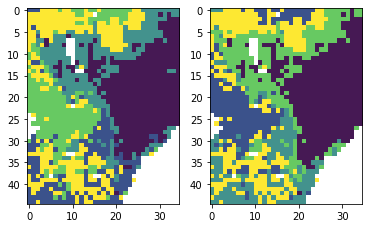

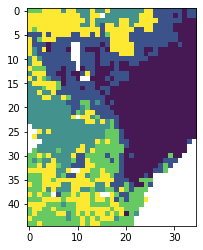

In [373]:
comparison_i = 2

_rm_dict = {0.0: 0.0, 1.0: 3.0, 2.0: 1.0, 3.0: 2.0, 4.0: 4.0}
colors_remapped = np.array(colors)[[int(v) for v in _rm_dict.values()]]

def plot_colormap(colors: List[str]):
    sns.palplot(colors)
    ax = plt.gca()
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(np.arange(5))
    
plot_colormap(colors)
plot_colormap(colors_remapped)

# 0->4, 1->2, 2->1, 3=3, 4->4
new_cmap = ListedColormap(colors_remapped)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cluster_ds.isel(time=0).cluster_5.values[::-1, :], cmap=cmap)
axs[1].imshow(cluster_ds.isel(time=comparison_i).cluster_5.values[::-1, :], cmap=cmap)

fig, ax = plt.subplots()
ax.imshow(cluster_ds.isel(time=comparison_i).cluster_5.values[::-1, :], cmap=new_cmap)

In [ ]:
## harcoding my best guess
remap_dicts = [
    {0.0: 0.0, 1.0: 1.0, 2.0: 2.0, 3.0: 3.0, 4.0: 4.0},
    {0.0: 4.0, 1.0: 2.0, 2.0: 1.0, 3.0: 3.0, 4.0: 0.0},
    {0.0: 0.0, 1.0: 3.0, 2.0: 1.0, 3.0: 2.0, 4.0: 4.0},
    {0.0: 0.0, 1.0: 2.0, 2.0: 1.0, 3.0: 3.0, 4.0: 4.0},
    {0.0: 0.0, 1.0: 2.0, 2.0: 1.0, 3.0: 3.0, 4.0: 4.0},
    {0.0: 0.0, 1.0: 2.0, 2.0: 1.0, 3.0: 3.0, 4.0: 4.0},
    {0.0: 0.0, 1.0: 2.0, 2.0: 1.0, 3.0: 3.0, 4.0: 4.0},
    {0.0: 0.0, 1.0: 2.0, 2.0: 1.0, 3.0: 3.0, 4.0: 4.0},
    {0.0: 0.0, 1.0: 2.0, 2.0: 1.0, 3.0: 3.0, 4.0: 4.0},
    {0.0: 0.0, 1.0: 2.0, 2.0: 1.0, 3.0: 3.0, 4.0: 4.0},
    {0.0: 0.0, 1.0: 2.0, 2.0: 1.0, 3.0: 3.0, 4.0: 4.0},
    {0.0: 0.0, 1.0: 2.0, 2.0: 1.0, 3.0: 3.0, 4.0: 4.0},
]

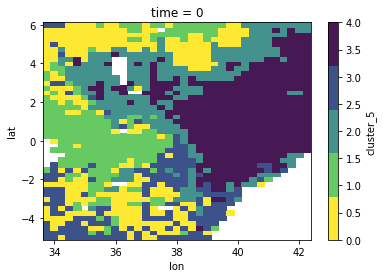

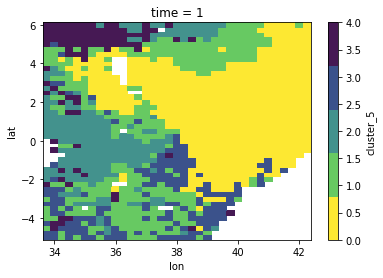

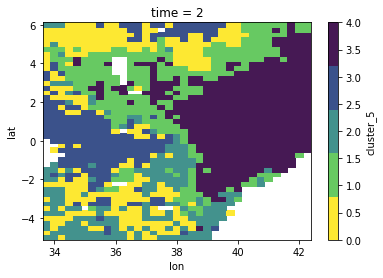

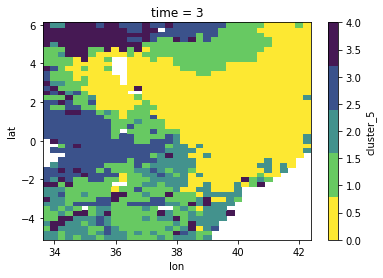

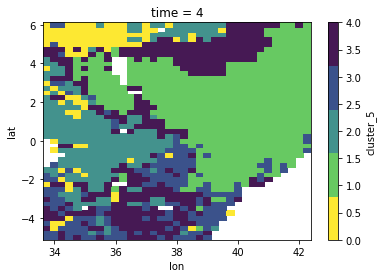

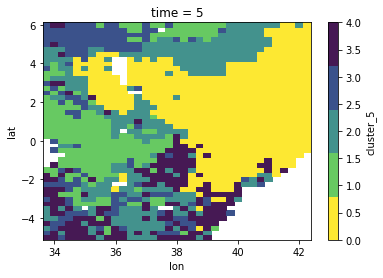

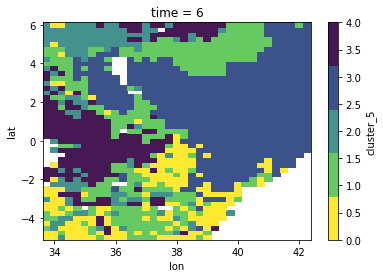

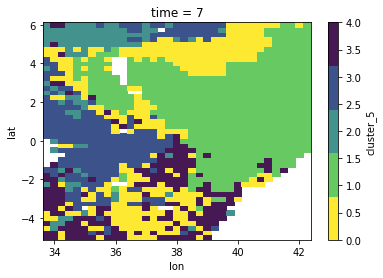

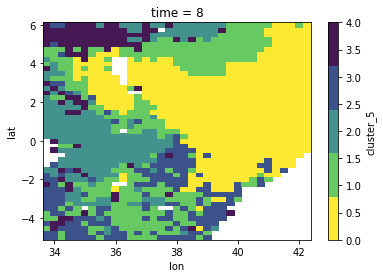

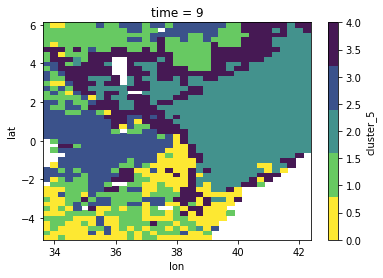

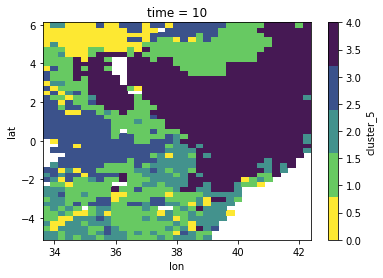

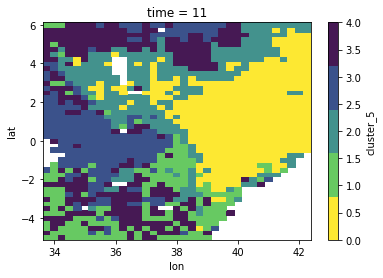

In [353]:
m_abbrs = [m for m in calendar.month_abbr]

# month_abbr = m_abbrs[1]
reference_ds = cluster_ds.isel(time=2).cluster_5
# plot_cluster_ds([5], reference_ds, month_abbr=month_abbr)

for time in cluster_ds.time.values:
    month_abbr = m_abbrs[time]
    comparison_ds = cluster_ds.isel(time=time).cluster_5
    
    remap_dict, _ = get_matching_groups(reference_ds, comparison_ds)
    
    colors_remapped = np.array(colors)[[int(v) for v in remap_dict.values()]]
    new_cmap = ListedColormap(colors_remapped)
#     print(remap_dict)
    
    fig, ax = plt.subplots()
    comparison_ds.plot(cmap=cmap, ax=ax)
    
#     remap_comparison = remap_xarray_values(
#         comparison_ds, lookup_dict=remap_dict, new_variable='cluster_5'
#     )
#     remap_comparison.plot(cmap=cmap, ax=ax)
    
#     plot_cluster_ds([5], comparison_ds, month_abbr=month_abbr, cmap=cmap)

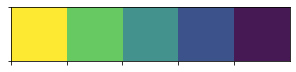

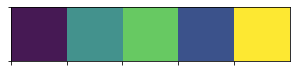

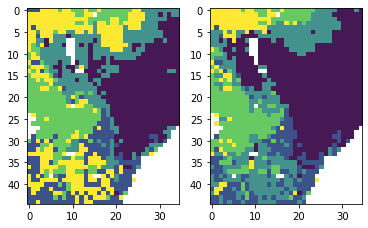

In [336]:
colors_remapped = np.array(colors)[[int(v) for v in remap_dict.values()]]
sns.palplot(colors)
sns.palplot(colors_remapped)

# 0->4, 1->2, 2->1, 3=3, 4->0
new_cmap = ListedColormap(colors_remapped)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cluster_ds.isel(time=0).cluster_5.values[::-1, :], cmap=cmap)
axs[1].imshow(cluster_ds.isel(time=1).cluster_5.values[::-1, :], cmap=new_cmap)

In [274]:
# # {group_0: {group_1_value: group_1_count}}
# unique_counts = dict()
# for value in np.unique(jan[~np.isnan(jan)]):
#     # count the number of matching pixels in each group
#     counts = np.unique(feb[jan == value], return_counts=True)
#     unique_counts[value] = dict(zip(counts[0], counts[1]))

               
# d = pd.DataFrame(unique_counts)  # rows = group_1_values, cols = group_0_values
# d.columns = d.columns.rename('group_0')
# d.index = d.index.rename('group_1')
# # 2D -> 1D idx, group_0, group_1, count
# d = d.unstack().reset_index().rename(columns={0: 'count'})

unique_counts = count_matching_pixels(reference_ds, comparison_ds)
df = convert_counts_dict_to_dataframe(unique_counts)

# get the counts of each pixel value/group (excl. nans) and select the most cross-overs
# order is important so we do the BEST match first
# get the largest first
group_0_list = []
group_1_list = []

max_count_row = get_max_count_row(df)
group_0_list.append(
    max_count_row.group_0
)
group_1_list.append(
    max_count_row.group_1
)

# drop_already_assigned_values
df = drop_already_assigned_values(
    df, group_1_list+group_0_list
)
# get_max_count_row
max_count_row = get_max_count_row(df)

group_0_list.append(
    max_count_row.group_0
)
group_1_list.append(
    max_count_row.group_1
)

# # drop_already_assigned_values
df = drop_already_assigned_values(
    df, group_1_list+group_0_list
)
df


def most_overlapping_pixels_algorithm() -> Dict Tuple[List[float], List[float]]:
    # get the counts of each pixel value/group (excl. nans) and select the most cross-overs
    # order is important so we do the BEST match first
    # get the largest first
    group_0_list = []
    group_1_list = []

    # match each reference_group to closest matching comparison_group
    # track progress by removing the matches that have already been made
    # from the dataframe
    while df.shape[0] > 0:
        # IF only one group-value left, assign it to the final remaining group (itself)
        if len(df.group_1.unique()) == 1:
            # final value is itself 
            # remap_dict[df.group_1.unique()[0]] = df.group_1.unique()[0]
            group_0_list.append(df.group_1.unique()[0])
            group_1_list.append(df.group_1.unique()[0])
            df = drop_already_assigned_values(
                df, group_1_list + group_0_list]
            )

        else:
            # otherwise match to the closest remaining match (most overlapping pixels)
            max_count_row = get_max_count_row(df)
            group_0_list.append(
                max_count_row.group_0
            )
            group_1_list.append(
                max_count_row.group_1
            )

            # drop_already_assigned_values
            df = drop_already_assigned_values(
                df, group_1_list+group_0_list
            )
            
    remap_dict = calculate_remap_dict(group_0_list, group_1_list)
    
    return remap_dict


def 
# def calculate_remap_dict(group_1_list):
#     

remap_dict = dict()
# remap dict is symmetrical: 
# values in group_0->group_1 are the same mapping as group_1-> group_0
remap_dict.update(dict(zip(group_0_list, group_1_list)))
remap_dict.update(dict(zip(remap_dict.values(), remap_dict.keys())))

# sort the remap_dict
remap_dict = {k :remap_dict[k]  for k in sorted(remap_dict)}

print(remap_dict)
df

{0.0: 4.0, 1.0: 2.0, 2.0: 1.0, 4.0: 0.0}


,group_0,group_1,count
18,3.0,3.0,160.0


False

In [249]:
from collections import OrderedDict

remap_dict = dict()

# final value is itself 
remap_dict[new_d2.group_1.unique()[0]] = new_d2.group_1.unique()[0]

# remap dict is symmetrical: 
# values in group_0->group_1 are the same mapping as group_1-> group_0
remap_dict.update(dict(zip(group_0_list, group_1_list)))
remap_dict.update(dict(zip(remap_dict.values(), remap_dict.keys())))

# sort the remap_dict
remap_dict = {k :remap_dict[k]  for k in sorted(remap_dict)}

remap_dict

{0.0: 4.0, 1.0: 2.0, 2.0: 1.0, 3.0: 3.0, 4.0: 0.0}

In [181]:
new_d2

,group_0,group_1,count
0,0.0,0.0,1.0
1,0.0,1.0,183.0
2,0.0,2.0,11.0
3,0.0,3.0,1.0
4,0.0,4.0,98.0
5,1.0,0.0,NaN
6,1.0,1.0,33.0
7,1.0,2.0,205.0
8,1.0,3.0,NaN
9,1.0,4.0,1.0


In [ ]:
def calculate_new_order() -> np.array:
    new_order = None
    return new_order

def create_new_cmap(colors: np.array, new_order: np.array) -> ListedColormap:
    """Reorder the colors by new_order and return a valid matplotlib colormap"""
    return ListedColormap(colors[new_order])

In [76]:
np.arange(0, 5)

array([0, 1, 2, 3, 4])

# MARGINALIA

In [ ]:
latitudes = latlons_data[:, 0]
longitudes = latlons_data[:, 1]
pixels = latlons

out = []
for k in ks:
    cluster = np.array([v for v in static_clusters[k].values()])
    coords = {'pixel': pixels}
    dims = ['pixel']
    cluster_ds = xr.Dataset({f'cluster_{k}': (dims, cluster), 'lat': (dims, latitudes), 'lon': (dims, longitudes),})
    out.append(cluster_ds)

static_cluster_ds = xr.auto_combine(out)
static_cluster_ds = static_cluster_ds.to_dataframe().set_index(['lat','lon']).to_xarray()

In [ ]:
# latitudes = latlons_data[:, 0]
# longitudes = latlons_data[:, 1]
pixels = latlons
convert_clusters_to_ds(ks, static_clusters=static_clusters, pixels=pixels)
pixels

### [UNNECESSARY] which of these neurons actually vary?

In [ ]:
threshold = 0.01

embedding = all_embeddings[0]
mask_same = np.all(np.isclose(embedding, embedding[0,:], threshold), axis=0)
print(f"How many neurons have the same values (thresh {threshold}): ".ljust(58), mask_same.sum())
print(f"How many neurons are left: ".ljust(58), len(mask_same) - mask_same.sum())
remove_constants = embedding[:, ~mask_same]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
pd.DataFrame({'std': np.std(embedding, axis=0)}, index=np.arange(0, 64)).plot.bar(ax=ax)

plt.legend(fontsize=16)
ax.set_title('Variability of the Static Embedding')
ax.set_ylabel('Standard Deviation')
ax.set_xlabel('Neuron')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] # + ax.get_xticklabels()
              + ax.get_yticklabels()):
    item.set_fontsize(20)

### Remove the Non-Varying neurons

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
img = ax.pcolor(remove_constants.T, cmap='plasma')
ax.set_xlabel("Pixels")
ax.set_ylabel("Input gate neuron")
ax.set_title("Input gate activations")
cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_ylabel("Activation")

# KMeans on the Embeddings

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Taken directly from Kratzert et al (2019) 
# https://github.com/kratzert/ealstm_regional_modeling/blob/master/papercode/clusterutils.py
from collections import defaultdict

ks = [3, 4, 5, 8]
clusters = {k: {} for k in ks}
for k in ks:
    clusterer = KMeans(n_clusters=k, random_state=0, init='k-means++',
                       n_init=200).fit(embedding)

    for pixel in range(embedding.shape[0]):
        emb = embedding[pixel, :]
        clusters[k][pixel] = clusterer.predict(emb.reshape(1, -1))[0]

In [ ]:
np.array([v for v in clusters[5].values()]).shape

In [ ]:
latitudes = latlons_data[:, 0]
longitudes = latlons_data[:, 1]
pixels = latlons

out = []
for k in ks:
    cluster = np.array([v for v in clusters[k].values()])
    coords = {'pixel': pixels}
    dims = ['pixel']
    cluster_ds = xr.Dataset({f'cluster_{k}': (dims, cluster), 'lat': (dims, latitudes), 'lon': (dims, longitudes),})
    out.append(cluster_ds)

cluster_ds = xr.auto_combine(out)
cluster_ds = cluster_ds.to_dataframe().set_index(['lat','lon']).to_xarray()

In [ ]:
for k in ks:
    fig, ax = plt.subplots(figsize=(12,8))
    cluster_ds[f'cluster_{k}'].plot(ax=ax)
    ax.set_title(f'Output of Static Embedding Clustering [k={k}]');

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]): # + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

# Compare with the output of the raw static data 
(what info does the EALSTM embedding actually contribute?)

In [ ]:
print(static_x.shape)
print(embedding.shape)

In [ ]:
# Taken directly from Kratzert et al (2019) 
# https://github.com/kratzert/ealstm_regional_modeling/blob/master/papercode/clusterutils.py
from collections import defaultdict

ks = [3, 4, 5, 8]
# def fit_kmeans(array: np.array, ks: List[int] = [4]) -> Dict[int, Dict[int, int]]:
static_clusters = {k: {} for k in ks}
for k in ks:
    clusterer = KMeans(n_clusters=k, random_state=0, init='k-means++',
                       n_init=200).fit(static_x)

    for pixel in range(embedding.shape[0]):
        emb = static_x[pixel, :]
        static_clusters[k][pixel] = clusterer.predict(emb.reshape(1, -1))[0]

In [ ]:
np.array([v for v in static_clusters[5].values()]).shape

In [ ]:
latitudes = latlons_data[:, 0]
longitudes = latlons_data[:, 1]
pixels = latlons

out = []
for k in ks:
    cluster = np.array([v for v in static_clusters[k].values()])
    coords = {'pixel': pixels}
    dims = ['pixel']
    cluster_ds = xr.Dataset({f'cluster_{k}': (dims, cluster), 'lat': (dims, latitudes), 'lon': (dims, longitudes),})
    out.append(cluster_ds)

static_cluster_ds = xr.auto_combine(out)
static_cluster_ds = static_cluster_ds.to_dataframe().set_index(['lat','lon']).to_xarray()

In [ ]:
for k in ks:
    fig, ax = plt.subplots(figsize=(12,8))
    static_cluster_ds[f'cluster_{k}'].plot(ax=ax)
    ax.set_title(f'Output of RAW Static Data Clustering [k={k}]');

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]): # + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

# Get Morris Gradients

In [ ]:
?ealstm.get_dataloader

In [ ]:
ealstm.ignore_vars =[v for v in ealstm.ignore_vars if v not in ['VCI3M', 'modis_ndvi']]
dl = ealstm.get_dataloader('train')
x = [x for x in dl]

In [ ]:
print(x[0][0][5][:10])
print(x[1][0][5][:10])

In [ ]:
test_arrays_loader = ealstm.get_dataloader(
                mode="train", batch_file_size=1, to_tensor=True
)
_, val = list(next(iter(test_arrays_loader)).items())[0]
var_names = val.var_names
x = val.x

In [ ]:
?ealstm._get_morris_explanations

In [ ]:
ealstm.explain(method='morris')